# 04_Component3_Persona_Clustering.ipynb



## 1. Environment Setup & Imports


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

sns.set(style="whitegrid")

## 2. Load Data & Precomputed Metrics


In [5]:
# ABSA sentiment averages per provider
# Expect a DataFrame with columns: provider_id, aspect, avg_sentiment
sent_df = pd.read_excel("absa_aspect_sentiment.xlsx") \
             .groupby(['record_id','aspect_category'])['polarity'] \
             .mean() \
             .unstack(fill_value=0)

# Gap metrics per provider
# Columns: provider_id, aspect, hybrid_gap
gap_df = pd.read_excel("gap_analysis_metrics.xlsx") \
            .groupby(['id','aspect'])['hybrid_gap'] \
            .mean() \
            .unstack(fill_value=0)

# Optional: overall satisfaction per provider
sat_df = pd.read_excel("gap_analysis_metrics.xlsx") \
            .groupby('id')['overall_satisfaction'] \
            .mean()

## 3. Combine into Provider‐Feature Matrix


In [6]:
# rename gap columns to indicate lower-is-better
gap_df = gap_df.add_prefix('gap_')
sent_df = sent_df.add_prefix('sent_')

# merge
providers = sent_df.join(gap_df, how='outer').fillna(0)
providers['overall_satisfaction'] = sat_df
providers.head()

,sent_environment,sent_learning_opportunities,sent_mentorship,sent_professional_networking,sent_team_collaboration,sent_technical_support,sent_workload,gap_career_guidance,gap_environment,gap_learning_opportunities,gap_mentorship,gap_professional_networking,gap_team_collaboration,gap_technical_support,gap_workload,overall_satisfaction
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.6,1.0,0.6,0.6,0.6,0.6,1.0,NaN
48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.6,1.0,1.0,1.0,NaN
56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
71,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
96,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


## 4. Student Preference Input


In [11]:
# Predefined importance weights for each aspect (sum to 1)
# Adjust these values based on stakeholder input or domain priorities

weights = {
    'mentorship':             0.20,  # strong emphasis on quality of mentorship
    'workload':               0.10,  # moderate concern for workload balance
    'learning_opportunities': 0.25,  # highest priority on hands‑on learning
    'environment':            0.10,  # comfort and tools matter moderately
    'team_collaboration':     0.15,  # importance of good teamwork and communication
    'professional_networking':0.10,  # value of building a professional network
    'career_guidance':        0.10   # need for feedback on career progression
}

# Normalize just to be safe
total = sum(weights.values())
weights = {asp: w/total for asp, w in weights.items()}

print("Using predefined, normalized weights:")
for asp, w in weights.items():
    print(f"  {asp:25s}: {w:.2f}")


Using predefined, normalized weights:
  mentorship               : 0.20
  workload                 : 0.10
  learning_opportunities   : 0.25
  environment              : 0.10
  team_collaboration       : 0.15
  professional_networking  : 0.10
  career_guidance          : 0.10


## 5. Scoring Model (Weighted Aggregation)


In [15]:
# 5.1 Prepare a DataFrame of normalized features (robust to missing columns)

from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Work on a copy
feat = providers.copy()

# 5.1 Identify which sentiment/gap columns actually exist
sent_cols = [col for col in feat.columns if col.startswith("sent_") and col.split("sent_")[1] in aspects]
gap_cols = [col for col in feat.columns if col.startswith("gap_") and col.split("gap_")[1] in aspects]

print("Found sentiment columns:", sent_cols)
print("Found gap columns     :", gap_cols)

# 5.2 Normalize sentiment features to [0,1] if any
if sent_cols:
    scaler_sent = MinMaxScaler()
    feat[sent_cols] = scaler_sent.fit_transform(feat[sent_cols])

# 5.3 Normalize gap features to [0,1] and invert if any
if gap_cols:
    scaler_gap = MinMaxScaler()
    feat[gap_cols] = scaler_gap.fit_transform(feat[gap_cols])
    feat[gap_cols] = 1.0 - feat[gap_cols]

## 5.4 Compute Recommendation Scores (Weighted Aggregation)

# Build combined feature list in weight order
combined_cols = []
for asp in aspects:
    col = f"sent_{asp}"
    if col in feat.columns:
        combined_cols.append(col)
for asp in aspects:
    col = f"gap_{asp}"
    if col in feat.columns:
        combined_cols.append(col)

# Build corresponding weight vector
weights_list = []
for asp in aspects:
    if f"sent_{asp}" in combined_cols:
        weights_list.append(weights[asp])
for asp in aspects:
    if f"gap_{asp}" in combined_cols:
        weights_list.append(weights[asp])

# Compute dot product
X = feat[combined_cols].values
w = np.array(weights_list)
feat['recommendation_score'] = X.dot(w)

## 5.5 Display Top Recommendations

top_recs = feat[['recommendation_score']].sort_values(
    by='recommendation_score', ascending=False
).head(10)
print(top_recs)


Found sentiment columns: ['sent_environment', 'sent_learning_opportunities', 'sent_mentorship', 'sent_professional_networking', 'sent_team_collaboration', 'sent_workload']
Found gap columns     : ['gap_career_guidance', 'gap_environment', 'gap_learning_opportunities', 'gap_mentorship', 'gap_professional_networking', 'gap_team_collaboration', 'gap_workload']
      recommendation_score
612                   1.45
338                   1.45
188                   1.35
324                   1.35
685                   1.35
847                   1.30
146                   1.25
234                   1.25
1002                  1.25
1005                  1.25


## 6. Explanations & Top Reasons


In [16]:
def explain(record_id, top_n=3):
    """
    For a given record (or provider) ID, compute the top_n aspects contributing
    to its recommendation_score and return formatted explanation lines.
    """
    row = feat.loc[record_id]
    contribs = {}

    # consider only aspects that have both sentiment and gap columns present
    for asp in aspects:
        sent_col = f"sent_{asp}"
        gap_col  = f"gap_{asp}"
        if sent_col in row.index and gap_col in row.index:
            contrib = weights[asp] * (row[sent_col] + row[gap_col])
            contribs[asp] = contrib

    # sort by contribution descending and take top_n
    top_aspects = sorted(contribs.items(), key=lambda x: x[1], reverse=True)[:top_n]

    # format explanation lines
    lines = [f"{asp}: weight={weights[asp]:.2f}, " \
             f"sentiment={row[f'sent_{asp}']:.2f}, gap={row[f'gap_{asp}']:.2f}, " \
             f"contrib={score:.2f}"
             for asp, score in top_aspects]
    return "\n".join(lines)

# Example usage for top-3 recommended records
top3 = feat['recommendation_score'].nlargest(3).index
for rid in top3:
    print(f"Record {rid} → recommendation_score = {feat.at[rid,'recommendation_score']:.2f}")
    print("Top contributing aspects:")
    print(explain(rid, top_n=3))
    print("-" * 40)


Record 338 → recommendation_score = 1.45
Top contributing aspects:
learning_opportunities: weight=0.25, sentiment=1.00, gap=1.00, contrib=0.50
mentorship: weight=0.20, sentiment=1.00, gap=1.00, contrib=0.40
team_collaboration: weight=0.15, sentiment=0.00, gap=1.00, contrib=0.15
----------------------------------------
Record 612 → recommendation_score = 1.45
Top contributing aspects:
learning_opportunities: weight=0.25, sentiment=1.00, gap=1.00, contrib=0.50
mentorship: weight=0.20, sentiment=1.00, gap=1.00, contrib=0.40
team_collaboration: weight=0.15, sentiment=0.00, gap=1.00, contrib=0.15
----------------------------------------
Record 188 → recommendation_score = 1.35
Top contributing aspects:
mentorship: weight=0.20, sentiment=1.00, gap=1.00, contrib=0.40
team_collaboration: weight=0.15, sentiment=1.00, gap=1.00, contrib=0.30
learning_opportunities: weight=0.25, sentiment=0.00, gap=1.00, contrib=0.25
----------------------------------------


## 7. Visualization of Ranked Providers


C:\Users\piyum\AppData\Local\Temp\ipykernel_14392\824298451.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


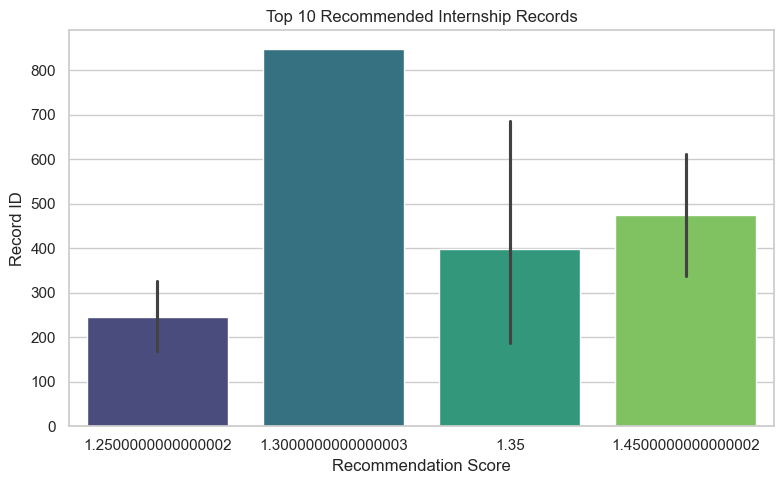

In [17]:
# Visualize Top 10 Recommendations

plt.figure(figsize=(8, 5))
# Prepare top 10 records
top10 = feat['recommendation_score'].nlargest(10).reset_index()
top10.columns = ['record_id', 'recommendation_score']

# Bar plot
sns.barplot(
    data=top10,
    x='recommendation_score',
    y='record_id',
    palette='viridis'
)
plt.title("Top 10 Recommended Internship Records")
plt.xlabel("Recommendation Score")
plt.ylabel("Record ID")
plt.tight_layout()
plt.show()


## 8. Save Recommendation Engine


In [18]:
feat.to_excel("provider_scores_and_features.xlsx")